In [67]:
import pandas as pd
import os

# Rutas de los archivos CSV
archivo1 = 'refrigerador.csv'  # Cambia esto por la ruta de tu primer archivo
archivo2 = 'ventilador.csv'    # Cambia esto por la ruta de tu segundo archivo

# Función para leer un archivo CSV y agregar la columna de dispositivo
def leer_archivo_con_dispositivo(archivo):
    # Extraer el nombre del dispositivo del nombre del archivo
    dispositivo = os.path.basename(archivo).split('_')[0]
    
    # Leer el archivo CSV
    df = pd.read_csv(archivo)
    
    # Agregar la columna de dispositivo
    df['dispositivo'] = dispositivo
    
    return df

# Leer los archivos CSV y agregar la columna de dispositivo
df1 = leer_archivo_con_dispositivo(archivo1)
df2 = leer_archivo_con_dispositivo(archivo2)

# Combinar los DataFrames
df_combined = pd.concat([df1, df2], ignore_index=True)

# Guardar el DataFrame combinado en un nuevo archivo CSV
archivo_combined = 'archivo_entrenamiento.csv'  # Nombre del archivo combinado
df_combined.to_csv(archivo_combined, index=False)

print(f"Archivos combinados y guardados en '{archivo_combined}'")


Archivos combinados y guardados en 'archivo_entrenamiento.csv'


In [68]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [69]:
# Cargar el conjunto de datos de entrenamiento
df_entrenamiento = pd.read_csv('archivo_entrenamiento.csv')

# Verificar los datos
print(df_entrenamiento.head())


                fecha     valor       dispositivo
0  2024-09-25_15-00-0  0.115783  refrigerador.csv
1  2024-09-25_15-00-1  0.115826  refrigerador.csv
2  2024-09-25_15-00-2  0.115671  refrigerador.csv
3  2024-09-25_15-00-2  0.115788  refrigerador.csv
4  2024-09-25_15-00-3  0.115788  refrigerador.csv


In [70]:
# Definir las características (X) y las etiquetas (y)
X = df_entrenamiento[['valor']]
y = df_entrenamiento['dispositivo']


In [71]:
# Dividir los datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [72]:
# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
modelo_rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [73]:
# Hacer predicciones sobre el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")

# Mostrar un informe detallado de la clasificación
print(classification_report(y_test, y_pred))


Precisión del modelo: 0.60
                  precision    recall  f1-score   support

refrigerador.csv       0.75      0.74      0.74      1497
  ventilador.csv       0.13      0.14      0.13       431

        accuracy                           0.60      1928
       macro avg       0.44      0.44      0.44      1928
    weighted avg       0.61      0.60      0.61      1928



In [78]:
# Cargar el archivo CSV con datos de múltiples dispositivos
df_multidispositivos = pd.read_csv('aparente.csv')

# Verificar los datos cargados
print(df_multidispositivos.head())


                fecha     valor
0  2024-09-25_15-00-0  0.115783
1  2024-09-25_15-00-1  0.115826
2  2024-09-25_15-00-2  0.115671
3  2024-09-25_15-00-2  0.115788
4  2024-09-25_15-00-3  0.115788


In [79]:
# Extraer las columnas necesarias para la predicción
X_nuevos = df_multidispositivos[['valor']]


In [80]:
# Realizar las predicciones con el modelo entrenado
predicciones = modelo_rf.predict(X_nuevos)

# Agregar las predicciones al DataFrame original
df_multidispositivos['dispositivo_predicho'] = predicciones

# Mostrar los primeros resultados
print(df_multidispositivos.head())


                fecha     valor dispositivo_predicho
0  2024-09-25_15-00-0  0.115783     refrigerador.csv
1  2024-09-25_15-00-1  0.115826     refrigerador.csv
2  2024-09-25_15-00-2  0.115671     refrigerador.csv
3  2024-09-25_15-00-2  0.115788     refrigerador.csv
4  2024-09-25_15-00-3  0.115788     refrigerador.csv


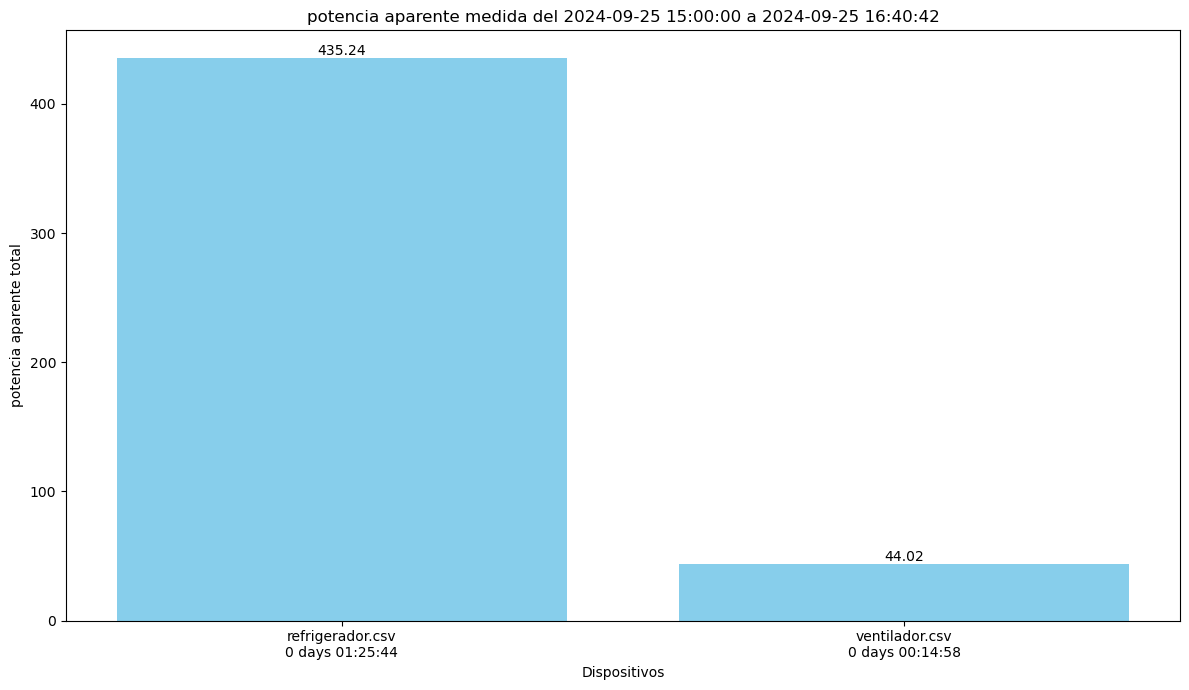

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Realizar las predicciones con el modelo entrenado
predicciones = modelo_rf.predict(X_nuevos)

# Agregar las predicciones al DataFrame original
df_multidispositivos['dispositivo_predicho'] = predicciones

# Convertir la columna de fecha al formato correcto
df_multidispositivos['fecha'] = pd.to_datetime(df_multidispositivos['fecha'], format='%Y-%m-%d_%H-%M-%S')
df_multidispositivos = df_multidispositivos.sort_values(by='fecha')

# Calcular la diferencia de tiempo entre las filas consecutivas
df_multidispositivos['tiempo_activo'] = df_multidispositivos['fecha'].diff().fillna(pd.Timedelta(seconds=0))

# Agrupar por dispositivo predicho y sumar los valores y el tiempo activo
valores_dispositivos = df_multidispositivos.groupby('dispositivo_predicho')['valor'].sum()
tiempo_dispositivos = df_multidispositivos.groupby('dispositivo_predicho')['tiempo_activo'].sum()

# Obtener el rango de tiempo total de la medición
fecha_inicio = df_multidispositivos['fecha'].min().strftime('%Y-%m-%d %H:%M:%S')
fecha_fin = df_multidispositivos['fecha'].max().strftime('%Y-%m-%d %H:%M:%S')

# Crear la gráfica de barras basada en la suma de valores
plt.figure(figsize=(12, 7))
bars = plt.bar(valores_dispositivos.index, valores_dispositivos.values, color='skyblue')

# Añadir los valores totales en la parte superior de las barras
for bar, total in zip(bars, valores_dispositivos.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{total:.2f}', ha='center', va='bottom')

# Añadir títulos y etiquetas, incluyendo el rango de tiempo total
plt.title(f'potencia aparente medida del {fecha_inicio} a {fecha_fin}')
plt.xlabel('Dispositivos')
plt.ylabel('potencia aparente total')

# Configurar etiquetas del eje x incluyendo el nombre y el tiempo de forma horizontal
etiquetas = [f"{dispositivo}\n{str(tiempo)}" for dispositivo, tiempo in zip(valores_dispositivos.index, tiempo_dispositivos)]
plt.xticks(range(len(valores_dispositivos.index)), etiquetas, rotation=0, ha='center')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


KeyError: 'refrigerador.csv'

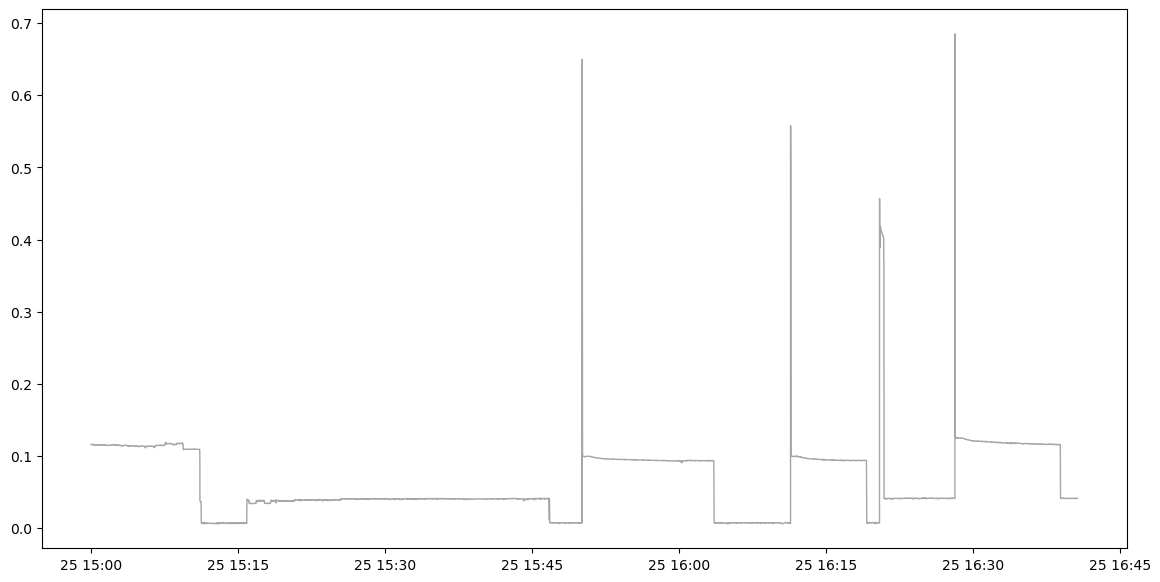

In [82]:
import matplotlib.pyplot as plt

# Configurar colores más fuertes para cada dispositivo
colores_prediccion = {'refrigerador': 'blue', 'ventilador': 'green'}

# Crear la gráfica de líneas
plt.figure(figsize=(14, 7))

# Graficar las corrientes reales (sin etiqueta de dispositivo)
plt.plot(df_multidispositivos['fecha'], df_multidispositivos['valor'], label='valor', color='gray', alpha=0.7, linewidth=1)

# Graficar las predicciones con colores más fuertes y líneas continuas
for dispositivo in df_multidispositivos['dispositivo_predicho'].unique():
    subset = df_multidispositivos[df_multidispositivos['dispositivo_predicho'] == dispositivo]
    plt.plot(subset['fecha'], subset['valor'], label=f'Predicción: {dispositivo}', color=colores_prediccion[dispositivo], linewidth=2)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Comparación entre Valores Reales y Predicciones de Dispositivos')
plt.xticks(rotation=45)
plt.legend()

# Ajustar el diseño para que todo encaje
plt.tight_layout()

# Mostrar la gráfica
plt.show()